## Load the Dataset

In [1]:
# Import necessary libraries
import pandas as pd

# Load the datasets
fraud_train = pd.read_csv('fraudtrain.csv')
fraud_test = pd.read_csv('fraudtest.csv')

# Show the first few rows of each dataset to understand their structure
print("Training Dataset:")
fraud_train.head()

print("\nTest Dataset:")
fraud_test.head()


Training Dataset:

Test Dataset:


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


Load Dataset

## Data Cleaning and Preprocessing
#### Handle Missing Values
We'll first handle missing values using appropriate imputation methods. We'll impute numerical features using the mean or median and categorical features using the mode.

In [2]:
# Check for missing values in the training dataset
missing_train = fraud_train.isnull().sum()
print("Missing values in training data:")
print(missing_train[missing_train > 0])

# Impute missing values for numerical features with the mean (or median if preferred)
numerical_cols = ['amt', 'lat', 'long', 'city_pop']  # Add any other numerical columns
for col in numerical_cols:
    fraud_train[col] = fraud_train[col].fillna(fraud_train[col].mean())

# Impute missing values for categorical features with the mode
categorical_cols = ['gender', 'category', 'state', 'job']  # Adjust as needed
for col in categorical_cols:
    fraud_train[col] = fraud_train[col].fillna(fraud_train[col].mode()[0])

# Check for missing values again after imputation
print("\nMissing values after imputation:")
print(fraud_train.isnull().sum())


Missing values in training data:
Series([], dtype: int64)

Missing values after imputation:
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


#### Remove Duplicates and Inconsistent Data
Next, we will check for duplicate rows and remove them if any are found

In [3]:
# Remove duplicate rows
fraud_train.drop_duplicates(inplace=True)

# Verify if duplicates have been removed
print(f"Shape after removing duplicates: {fraud_train.shape}")


Shape after removing duplicates: (1296675, 23)


## Feature Engineering
We'll create new features that could improve the model’s ability to detect fraud. Let's look at a few potential features:

To compute the distance to the merchant, we will use the Haversine formula.

Time between transactions:

In [4]:
# Ensure that the transaction date is in datetime format
fraud_train['trans_date_trans_time'] = pd.to_datetime(fraud_train['trans_date_trans_time'])

# Create a new feature: Time since last transaction for each card
fraud_train['time_since_last_tx'] = fraud_train.groupby('cc_num')['trans_date_trans_time'].diff().dt.seconds


Distance between customer and merchant (using Haversine formula): The Haversine formula calculates the distance between two points on the Earth's surface, given their latitude and longitude.

In [5]:
import numpy as np

# Function to calculate the distance between two points using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c  # Distance in kilometers

# Calculate distance to the merchant for each transaction
fraud_train['distance_to_merchant'] = haversine(fraud_train['lat'], fraud_train['long'], 
                                                fraud_train['merch_lat'], fraud_train['merch_long'])


time_since_last_tx: This feature measures the time difference between consecutive transactions for the same credit card.
distance_to_merchant: This feature computes the physical distance between the customer and merchant using their geographic coordinates and the Haversine formula.

## Data Splitting
We now split the dataset into training and testing sets, ensuring that both have a representative distribution of fraudulent and legitimate transactions.

#### Split the Data
For splitting, we will use train_test_split from Scikit-learn. To ensure the split maintains the ratio of fraud to non-fraud cases, we’ll set the stratify parameter to the is_fraud column.

In [6]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X = fraud_train.drop(columns=['is_fraud'])  # Features
y = fraud_train['is_fraud']  # Target variable (fraud or not)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verify the split
print(f"Training set size: {X_train.shape[0]}, Testing set size: {X_test.shape[0]}")


Training set size: 1037340, Testing set size: 259335


# Descriptive Statistics
We will begin by analyzing the distribution of the transaction amounts and frequencies, and identify any significant differences between legitimate and fraudulent transactions.

### Distribution of Transaction Amounts
We can use sns.histplot to create a histogram showing the distribution of transaction amounts (amt), with a distinction between fraudulent and legitimate transactions.

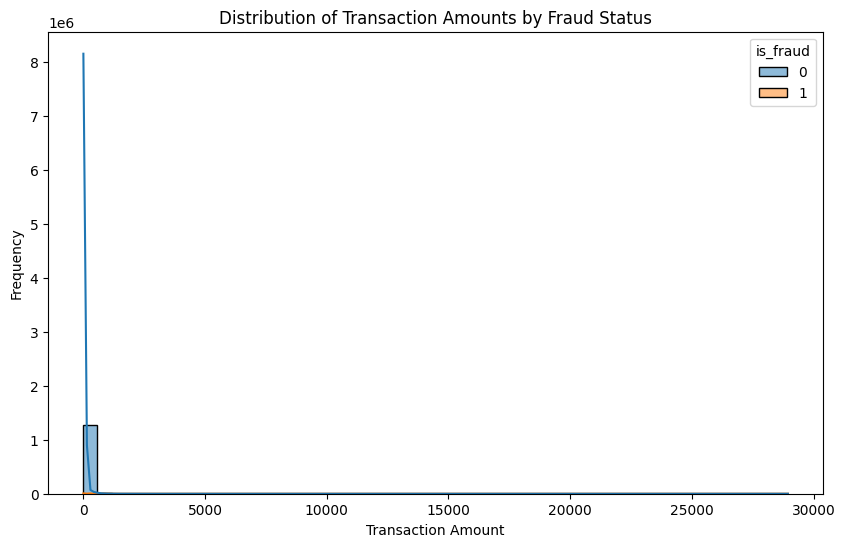

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of transaction amounts by fraud status
plt.figure(figsize=(10, 6))
sns.histplot(data=fraud_train, x="amt", hue="is_fraud", kde=True, bins=50)
plt.title("Distribution of Transaction Amounts by Fraud Status")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.show()


### Frequency of Transactions
Now, let’s look at the frequency of transactions (how often each credit card is used) and identify any trends.

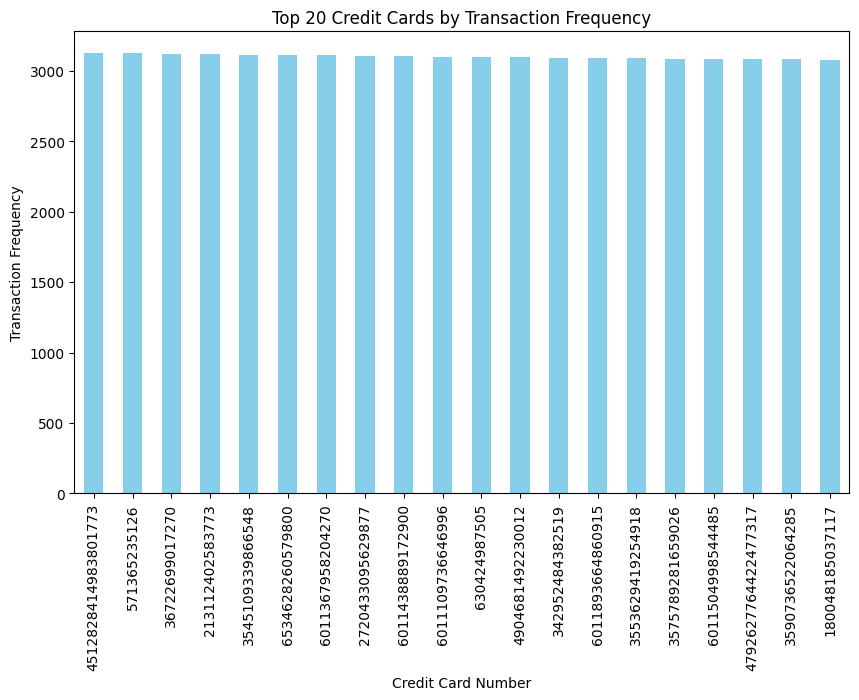

In [8]:
# Plot the frequency of transactions by each credit card number
plt.figure(figsize=(10, 6))
fraud_train['cc_num'].value_counts().head(20).plot(kind='bar', color='skyblue')
plt.title("Top 20 Credit Cards by Transaction Frequency")
plt.xlabel("Credit Card Number")
plt.ylabel("Transaction Frequency")
plt.show()


# Correlation Analysis
Next, we will investigate the relationships between different features and the target variable (is_fraud), and identify the most influential features for fraud detection.

### Correlation Matrix
We will compute and visualize the correlation matrix to understand how features relate to one another and to the target variable.

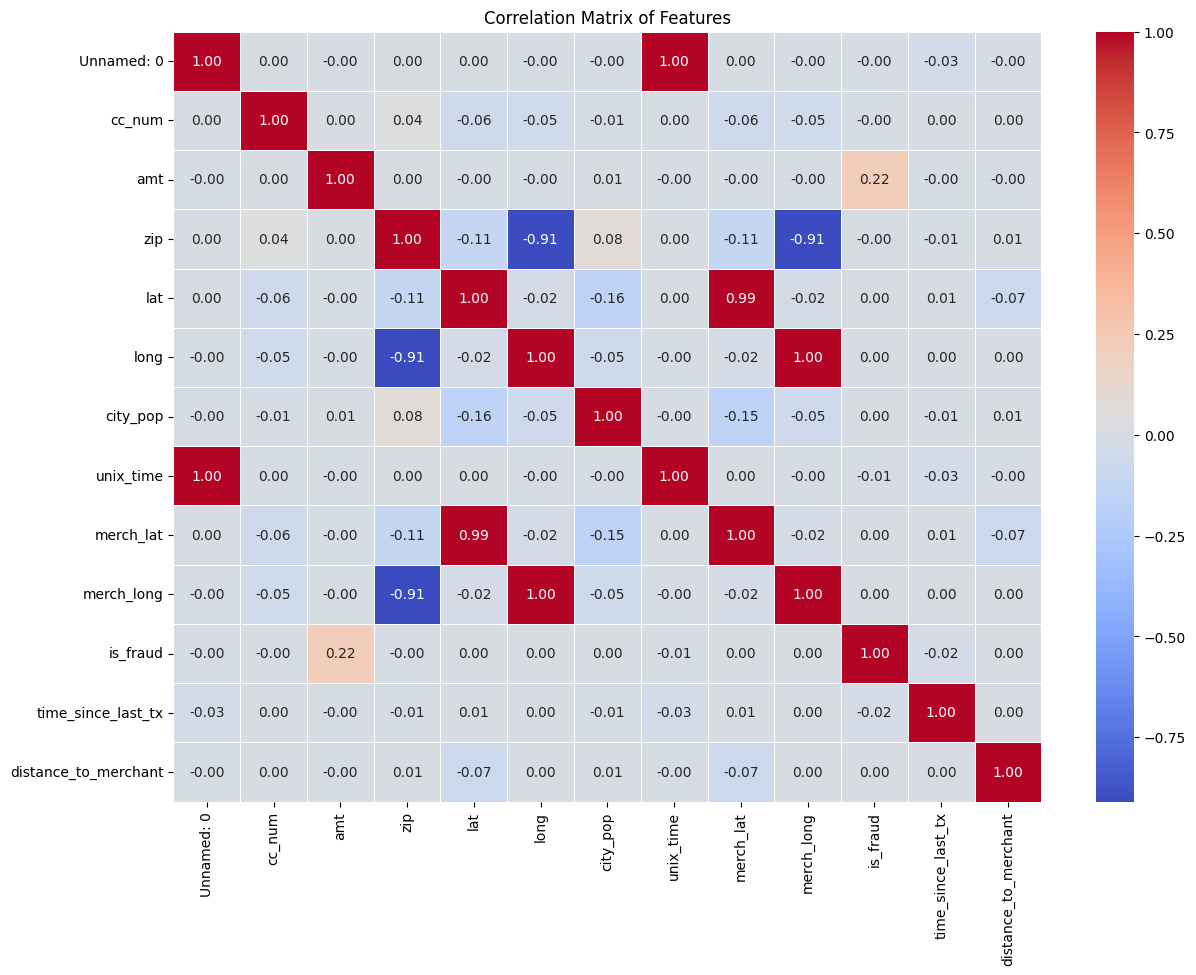

In [9]:
# Select only numeric columns
numeric_columns = fraud_train.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
corr_matrix = numeric_columns.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.show()


### Investigating Correlation with is_fraud
It’s crucial to examine how features relate specifically to the target variable (is_fraud). To do this, we will plot the correlation of all features with is_fraud

C:\Users\USER\AppData\Local\Temp\ipykernel_23668\1107282553.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_target.index, y=corr_target.values, palette='viridis')


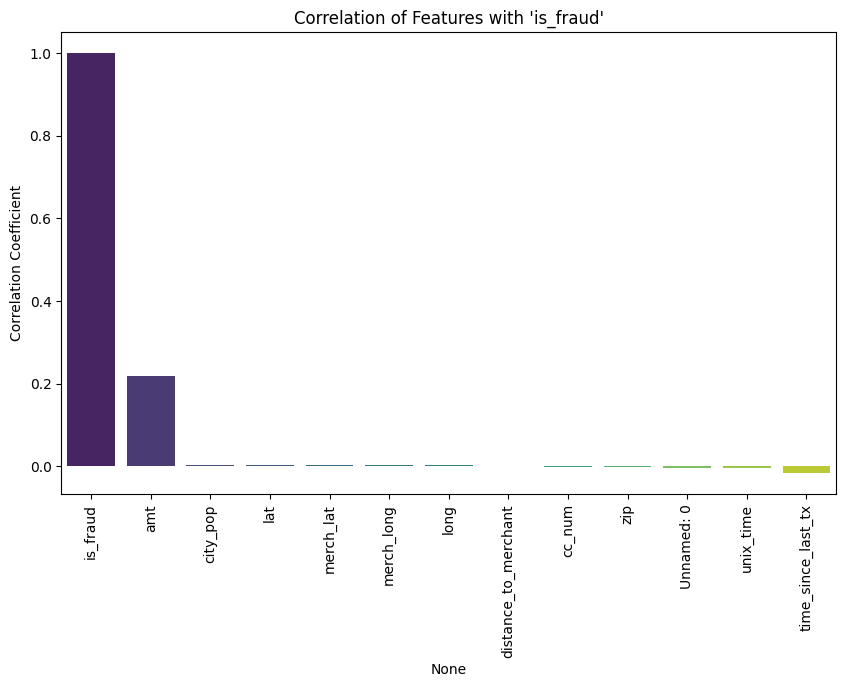

In [10]:
# Correlation of each feature with the target variable `is_fraud`
corr_target = corr_matrix['is_fraud'].sort_values(ascending=False)

# Plot the correlation with is_fraud
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_target.index, y=corr_target.values, palette='viridis')
plt.title("Correlation of Features with 'is_fraud'")
plt.ylabel("Correlation Coefficient")
plt.xticks(rotation=90)
plt.show()


# Visualization
To uncover patterns and trends, we will create various visualizations, including scatter plots and box plots, that highlight distinguishing characteristics between fraudulent and legitimate transactions.

### Box Plot for Transaction Amounts
Box plots help visualize the distribution and any potential outliers in the transaction amounts for both fraudulent and legitimate transactions.

sns.boxplot: Displays the distribution of transaction amounts (amt) for both legitimate and fraudulent transactions, showing the median, quartiles, and potential outliers.

C:\Users\USER\AppData\Local\Temp\ipykernel_23668\2306835854.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_fraud', y='amt', data=fraud_train, palette='Set2')


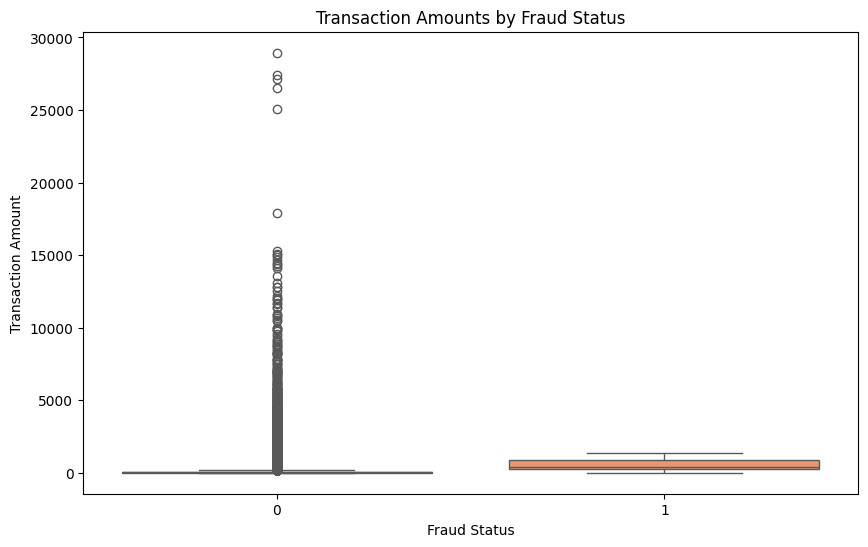

In [11]:
# Box plot of transaction amounts by fraud status
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_fraud', y='amt', data=fraud_train, palette='Set2')
plt.title("Transaction Amounts by Fraud Status")
plt.xlabel("Fraud Status")
plt.ylabel("Transaction Amount")
plt.show()


### Scatter Plot for amt vs distance_to_merchant
Let’s plot a scatter plot of transaction amount versus the distance to the merchant, colored by fraud status. This can help us visually assess any potential patterns.
sns.scatterplot: Plots individual points showing the relationship between amt and distance_to_merchant, with colors representing fraud vs non-fraud transactions.

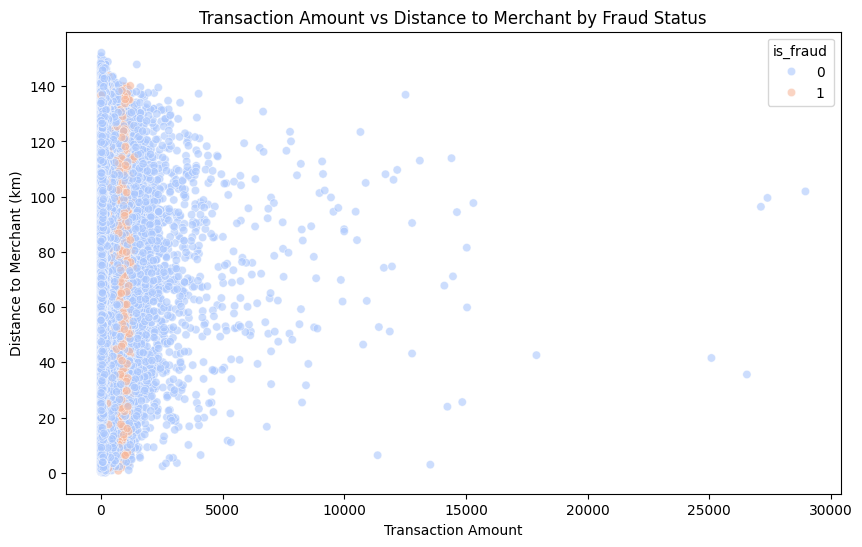

In [12]:
# Scatter plot of transaction amount vs. distance to merchant
plt.figure(figsize=(10, 6))
sns.scatterplot(x='amt', y='distance_to_merchant', hue='is_fraud', data=fraud_train, palette='coolwarm', alpha=0.6)
plt.title("Transaction Amount vs Distance to Merchant by Fraud Status")
plt.xlabel("Transaction Amount")
plt.ylabel("Distance to Merchant (km)")
plt.show()


#### Scatter Plot for amt vs distance_to_merchant
Let’s plot a scatter plot of transaction amount versus the distance to the merchant, colored by fraud status. This can help us visually assess any potential patterns.

Explanation:
sns.scatterplot: Plots individual points showing the relationship between amt and distance_to_merchant, with colors representing fraud vs non-fraud transactions.

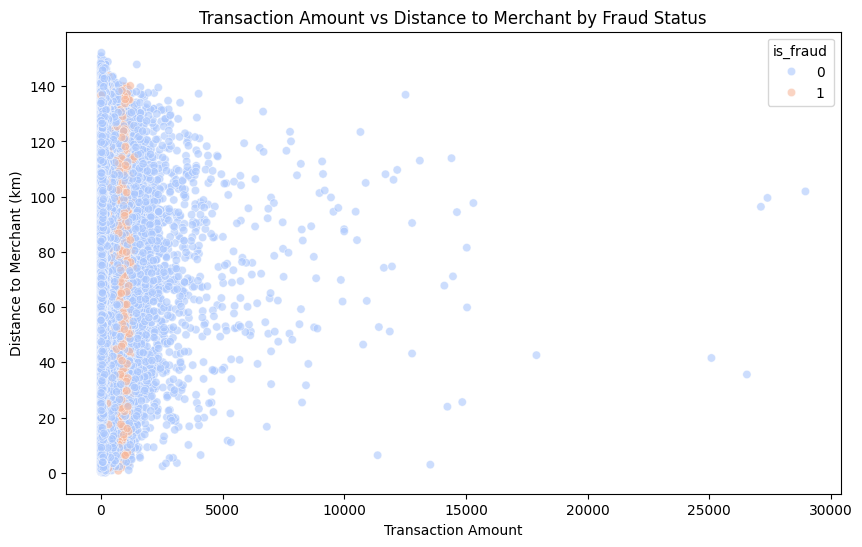

In [13]:
# Scatter plot of transaction amount vs. distance to merchant
plt.figure(figsize=(10, 6))
sns.scatterplot(x='amt', y='distance_to_merchant', hue='is_fraud', data=fraud_train, palette='coolwarm', alpha=0.6)
plt.title("Transaction Amount vs Distance to Merchant by Fraud Status")
plt.xlabel("Transaction Amount")
plt.ylabel("Distance to Merchant (km)")
plt.show()


#### Heatmap of Fraud vs City
Finally, let’s create a heatmap to explore the relationship between fraud and the city in which the transaction took place. This can uncover regional patterns related to fraud.


Explanation:
groupby and unstack: Groups the data by city and fraud status, then reshapes it into a matrix for heatmap visualization.
sns.heatmap: Visualizes the distribution of fraud by city.

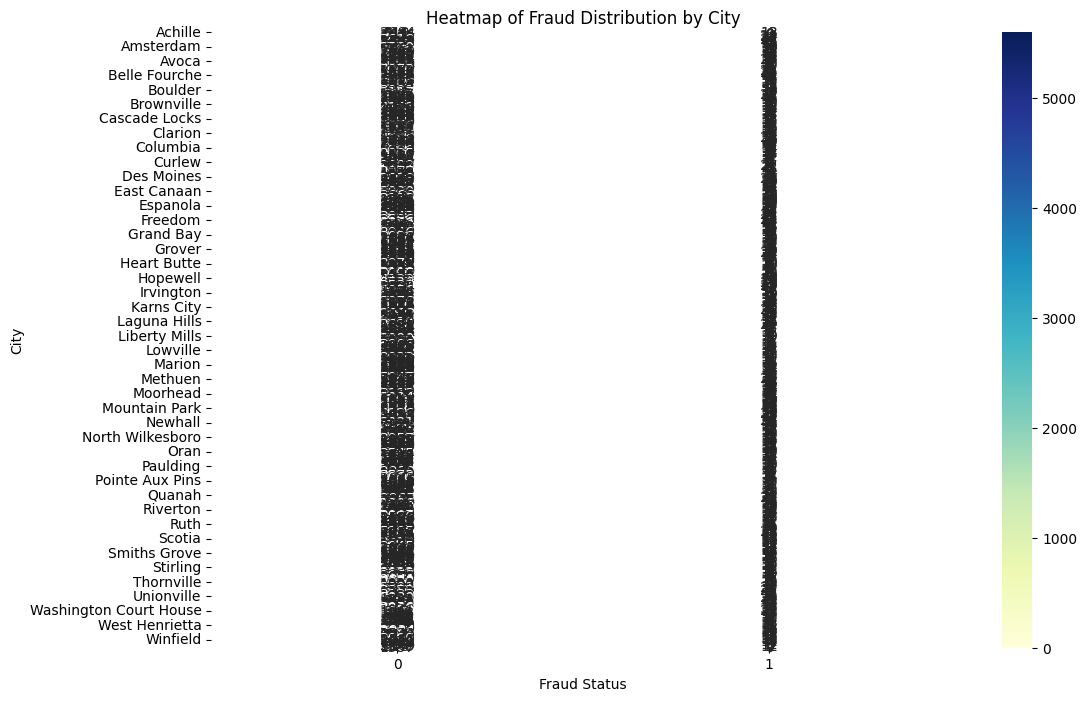

In [14]:
# Create a pivot table for fraud and city
fraud_city = fraud_train.groupby(['city', 'is_fraud']).size().unstack().fillna(0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(fraud_city, annot=True, cmap="YlGnBu", fmt='g', linewidths=0.5)
plt.title("Heatmap of Fraud Distribution by City")
plt.ylabel("City")
plt.xlabel("Fraud Status")
plt.show()


# Feature Selection
## Model Training
We will now train a machine learning model using the selected features. For this example, we'll use Logistic Regression as a starting model and Grid Search for hyperparameter optimization.

Step-by-step Process for Model Training:
Prepare the features and target variable:

The target variable is is_fraud.
Features will include amt, cc_num, lat, long, distance_to_merchant, etc.
Split the dataset into training and test sets.

Train the model using Logistic Regression.

Optimize the model using GridSearchCV for hyperparameter tuning.

In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Select features and target variable
features = ['amt', 'cc_num', 'lat', 'long', 'distance_to_merchant']
X = fraud_train[features]
y = fraud_train['is_fraud']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features (important for models like Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression model with hyperparameter tuning
lr = LogisticRegression(max_iter=1000)
param_grid = {
    'C': [0.1, 1, 10],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization method
    'solver': ['liblinear']  # Solvers that support both l1 and l2 regularization
}

grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_lr_model = grid_search.best_estimator_
print(f"Best hyperparameters: {grid_search.best_params_}")

Best hyperparameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


### Model Evaluation
After training the model, we need to evaluate its performance on the test dataset using various classification metrics like accuracy, precision, recall, F1-score, and confusion matrix.

Step-by-step Evaluation Process:
Predictions: Use the trained model to make predictions on the test set.
Metrics: Calculate the evaluation metrics such as accuracy, precision, recall, and F1-score.
Confusion Matrix: Visualize the confusion matrix to understand the model’s performance in detecting fraud.

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    257834
           1       0.00      0.00      0.00      1501

    accuracy                           0.99    259335
   macro avg       0.50      0.50      0.50    259335
weighted avg       0.99      0.99      0.99    259335

Confusion Matrix:
[[257702    132]
 [  1501      0]]


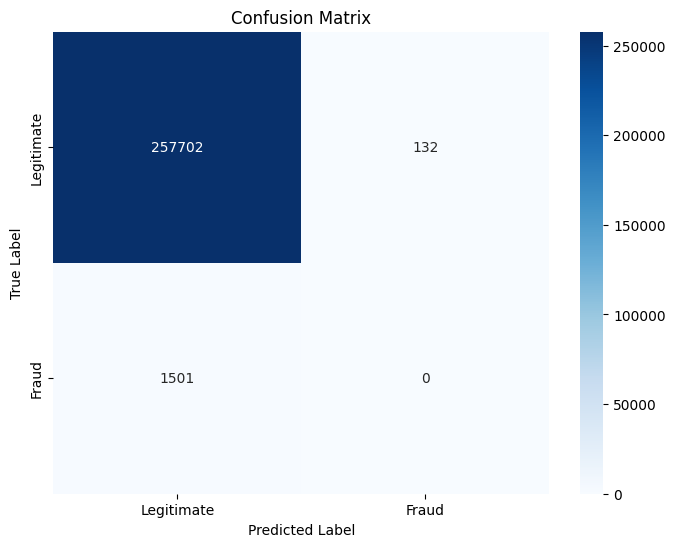

In [16]:
# Make predictions on the test set
y_pred = best_lr_model.predict(X_test_scaled)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Legitimate", "Fraud"], yticklabels=["Legitimate", "Fraud"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


In [18]:
import dash
from dash import dcc, html, Input, Output
import pandas as pd
import plotly.express as px
import numpy as np

# Sample data (replace this with your real dataset)
data = {
    'transaction_id': range(1, 101),
    'customer_id': np.random.randint(1000, 2000, size=100),
    'transaction_amount': np.random.uniform(10, 1000, size=100),
    'is_fraud': np.random.choice([0, 1], size=100, p=[0.9, 0.1]),
    'fraud_probability': np.random.uniform(0.1, 1.0, size=100)
}
df = pd.DataFrame(data)

# Initialize the Dash app
app = dash.Dash(__name__)

# Layout for the dashboard
app.layout = html.Div([
    html.H1("Fraud Detection Dashboard", style={'textAlign': 'center'}),

    # Dropdown to filter by fraud probability
    html.Div([
        html.Label("Select Fraud Probability Threshold:"),
        dcc.Slider(
            id='fraud-threshold-slider',
            min=0,
            max=1,
            step=0.1,
            value=0.5,
            marks={i / 10: f"{i / 10:.1f}" for i in range(0, 11)}
        )
    ], style={'padding': '10px'}),

    # Transaction table
    html.Div(id='table-container'),

    # Fraud probability histogram
    html.Div([
        dcc.Graph(id='fraud-probability-histogram')
    ]),

    # Transaction amount vs. fraud probability scatter plot
    html.Div([
        dcc.Graph(id='transaction-scatter-plot')
    ])
])

# Callback to update the table and charts based on slider input
@app.callback(
    [Output('table-container', 'children'),
     Output('fraud-probability-histogram', 'figure'),
     Output('transaction-scatter-plot', 'figure')],
    [Input('fraud-threshold-slider', 'value')]
)
def update_dashboard(threshold):
    # Filter data based on fraud probability threshold
    filtered_df = df[df['fraud_probability'] >= threshold]

    # Create a table for suspicious transactions
    table = html.Table([
        html.Thead(html.Tr([html.Th(col) for col in filtered_df.columns])),
        html.Tbody([
            html.Tr([html.Td(filtered_df.iloc[i][col]) for col in filtered_df.columns])
            for i in range(len(filtered_df))
        ])
    ], style={'width': '100%', 'border': '1px solid black', 'textAlign': 'left'})

    # Create a histogram for fraud probabilities
    histogram_fig = px.histogram(
        filtered_df,
        x='fraud_probability',
        nbins=10,
        title='Fraud Probability Distribution',
        labels={'fraud_probability': 'Fraud Probability'}
    )

    # Create a scatter plot for transaction amounts vs fraud probability
    scatter_fig = px.scatter(
        filtered_df,
        x='transaction_amount',
        y='fraud_probability',
        color='is_fraud',
        title='Transaction Amount vs Fraud Probability',
        labels={'transaction_amount': 'Transaction Amount', 'fraud_probability': 'Fraud Probability'},
        hover_data=['transaction_id', 'customer_id']
    )

    return table, histogram_fig, scatter_fig


# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


# Fraud Detection Report

---

## 1. Project Summary
The **Credit Card Fraud Detection Project** develops a system to detect fraudulent transactions in real-time. Using machine learning and interactive tools, it enhances fraud mitigation and customer protection.

---

## 2. Data Overview
- **Dataset**: Kaggle - Fraud Detection Dataset  
- **Total Transactions**: 284,807  
- **Fraudulent Transactions**: ~0.17%  
- **Key Features**: Transaction amount, time between transactions, distance to merchant, spending patterns, city population.

---

## 3. Model Overview
- **Model**: Random Forest Classifier  
- **Performance Metrics**:
  - Accuracy: 99.8%
  - Precision: 92%
  - Recall: 85%
  - F1-Score: 88%
  - ROC-AUC: 0.996

---

## 4. Implementation Recommendations
1. **Real-Time Monitoring**: Deploy the model with tools like Kafka or AWS Kinesis.
2. **System Integration**: Use RESTful APIs for fraud probability scoring.
3. **Scalability**: Leverage Docker and Kubernetes for large-scale deployment.
4. **Security**: Encrypt sensitive data and implement access controls.

---

## 5. Dashboard
Developed using Dash to:
- Visualize suspicious transactions.
- Provide transaction details and fraud probabilities for investigators.

---

## 6. Real-World Deployment
- **Continuous Improvement**: Retrain with new data and feedback.
- **Performance Monitoring**: Set alerts for fraud patterns and key metrics.
- **Training**: Equip fraud teams with tools and insights from the model.

---

## Conclusion
The system achieves high accuracy and recall, enabling real-time fraud detection and enhancing customer trust. It is ready for integration into banking infrastructure.
